In [2]:
import os, json
import torch.optim as optim
import torch.nn as nn
from qiskit.providers.fake_provider import FakeLima
from scripts.data_setup import load_data
from scripts.from_circ_to_numpy import operations_to_features, save_to_json, load_from_json
from scripts.model import create_models, train_and_test_step, save_models, load_models, run_models
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit.quantumcircuit import QuantumCircuit

In [3]:
n_qubits = 5 # 5 == n_qubits, default value for now because of FakeLima
data_dir = 'data_small_1'
train_circuits, train_observables, train_ideal_exp_vals, train_noisy_exp_vals, test_circuits, test_observables, test_ideal_exp_vals, test_noisy_exp_vals = load_data(f'data/circuits/{data_dir}')
X_train, y_train, X_test, y_test = load_from_json(f'data/features/{data_dir}')

In [4]:
models_directory = 'experiments/test_1/models'
results_directory = 'experiments/test_1/results'

train_losses_dict = {}

for result_file in os.listdir(results_directory):
    if result_file.endswith('.json'):
        result_path = os.path.join(results_directory, result_file)
        with open(result_path, 'r') as f:
            results = json.load(f)
        train_losses_dict[result_file] = results['train_losses']

top_5_models = sorted(train_losses_dict.items(), key=lambda x: min(x[1]))[:10]

model_info_list = []

for model_file, _ in top_5_models:
    model_name = model_file.replace('results_', '').replace('.json', '')
    model_path = f'{models_directory}/{model_name}'
    sequence_model, ann = load_models(model_path)

    with open(os.path.join(results_directory, model_file), "r") as f:
        results = json.load(f)
        test_loss = min(results['test_losses'])

    with open(f'{model_path}/sequence_config.json', "r") as f:
        sequence_config = json.load(f)

    with open(f'{model_path}/ann_config.json', "r") as f:
        ann_config = json.load(f)

    model_info_list.append({
        "model_name": model_name,
        "sequence_config": sequence_config,
        "ann_config": ann_config,
        "test_loss": test_loss
    })

sorted_model_info_list = sorted(model_info_list, key=lambda x: x["test_loss"])

for model_info in sorted_model_info_list:
    print(f"Model: {model_info['model_name']}")
    print("Sequence Config:")
    print(model_info['sequence_config'])
    print("ANN Config:")
    print(model_info['ann_config'])
    print(f"Test Loss: {model_info['test_loss']}")
    print()

Model: model_29
Sequence Config:
{'input_size': 7, 'hidden_size': 1, 'num_layers': 2, 'model_type': 'LSTM', 'dropout': 0}
ANN Config:
{'hidden_layers': 2, 'hidden_units': 16, 'dropout': 0, 'noisy_first': True}
Test Loss: 0.20266353631385475

Model: model_11
Sequence Config:
{'input_size': 7, 'hidden_size': 1, 'num_layers': 1, 'model_type': 'LSTM', 'dropout': 0}
ANN Config:
{'hidden_layers': 1, 'hidden_units': 32, 'dropout': 0, 'noisy_first': True}
Test Loss: 0.20348761254282072

Model: model_15
Sequence Config:
{'input_size': 7, 'hidden_size': 1, 'num_layers': 1, 'model_type': 'LSTM', 'dropout': 0}
ANN Config:
{'hidden_layers': 2, 'hidden_units': 32, 'dropout': 0, 'noisy_first': True}
Test Loss: 0.20444193493765955

Model: model_27
Sequence Config:
{'input_size': 7, 'hidden_size': 1, 'num_layers': 2, 'model_type': 'LSTM', 'dropout': 0}
ANN Config:
{'hidden_layers': 1, 'hidden_units': 32, 'dropout': 0, 'noisy_first': True}
Test Loss: 0.20562116029899905

Model: model_9
Sequence Config:


In [5]:
loss_fn = nn.MSELoss()

In [6]:
def model_eval(sequence_model, ann, loss_fn, X, noisy_exp_vals, y, noisy_first):
    sequence_model.eval()
    ann.eval()

    test_loss = 0
    circuit_depths = []
    test_losses = []

    with torch.inference_mode():
        for i in range(len(X)):
            y_pred = run_models(sequence_model, ann, X[i], noisy_exp_vals[i], noisy_first)

            loss = loss_fn(y_pred, y[i].unsqueeze(dim=0))

            test_loss += loss.item()

            transpiled_circuit = transpile(test_circuits[i], optimization_level=0, backend=backend)
            circuit_depths.append(transpiled_circuit.depth())

            test_losses.append(loss.item())

    return test_losses, circuit_depths


models_directory = 'experiments/test_1/models'
results_directory = 'experiments/test_1/results'

train_losses_dict = {}

for result_file in os.listdir(results_directory):
    if result_file.endswith('.json'):
        result_path = os.path.join(results_directory, result_file)
        with open(result_path, 'r') as f:
            results = json.load(f)
        train_losses_dict[result_file] = results['train_losses']

top_2_models = sorted(train_losses_dict.items(), key=lambda x: min(x[1]))[:2]

model_info_list = []

for model_file, _ in top_2_models:
    model_name = model_file.replace('results_', '').replace('.json', '')
    model_path = f'{models_directory}/{model_name}'
    sequence_model, ann = load_models(model_path)

    with open(os.path.join(results_directory, model_file), "r") as f:
        results = json.load(f)
        test_loss = min(results['test_losses'])

    with open(f'{model_path}/sequence_config.json', "r") as f:
        sequence_config = json.load(f)

    with open(f'{model_path}/ann_config.json', "r") as f:
        ann_config = json.load(f)

    model_info_list.append({
        "model_name": model_name,
        "sequence_config": sequence_config,
        "ann_config": ann_config,
        "test_loss": test_loss
    })

test_results = []
backend = FakeLima()

for model_info in model_info_list:
    sequence_model, ann = load_models(f'{models_directory}/{model_info["model_name"]}')
    test_loss, circuit_depths = model_eval(sequence_model, ann, loss_fn, X_test, test_noisy_exp_vals, y_test,
                                            model_info["ann_config"]["noisy_first"])

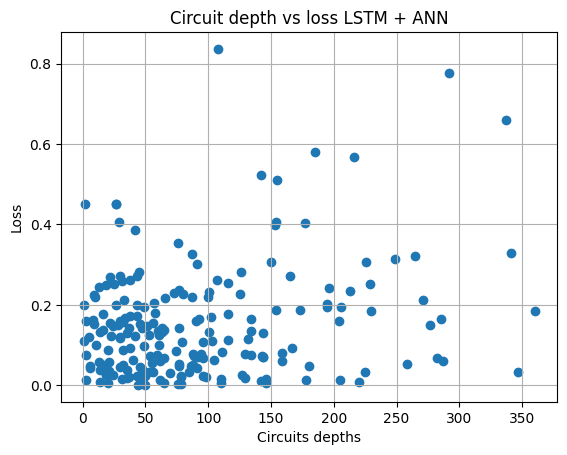

In [7]:
plt.scatter(circuit_depths, np.sqrt(test_loss))
plt.xlabel('Circuits depths')
plt.ylabel('Loss')
plt.title('Circuit depth vs loss LSTM + ANN')
plt.grid(True)
plt.show()

In [8]:
sequence_model.eval()
ann.eval()

y_pred_paper = []

with torch.inference_mode():
    for i in range(len(X_test)):
        y_pred_paper.append(run_models(sequence_model, ann, X_test[i], test_noisy_exp_vals[i], True).detach().cpu().numpy())

from sklearn.metrics import root_mean_squared_error

In [9]:
root_mean_squared_error(test_ideal_exp_vals, y_pred_paper)

0.2071923309972145